In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import os

# Base path that can be modified according to the system
base_path = "/home/darksst/Desktop/FacialExpressionRecognitionUsingDensenet121/"

def densenet(input_shape, n_classes, filters=32):
    def bn_rl_conv(x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides, padding='same')(x)
        return x

    def dense_block(x, repetitions):
        for _ in range(repetitions):
            y = bn_rl_conv(x, 4 * filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y, x])
        return x

    def transition_layer(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x

    input_layer = Input(input_shape)
    x = Conv2D(64, 3, strides=1, padding='same')(input_layer)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    for repetitions in [6, 12, 24, 16]:
        d = dense_block(x, repetitions)
        x = transition_layer(d)
    
    x = GlobalAveragePooling2D()(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

# Setup paths using the base path
data_dir = os.path.join(base_path, 'project_1_dataset/train')

# Data generators with augmentation
datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=16,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=16,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation')

# Create the model
model = densenet((48, 48, 1), 7)  # 7 classes
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#print(model.summary())

# Freeze the layers up to the third transition layer
transition_layer_count = 0
for layer in model.layers:
    if 'avg_pool' in layer.name:  # Assuming each transition layer includes AvgPool2D
        transition_layer_count += 1
    if transition_layer_count <= 15:
        layer.trainable = False

# Train the model
history = model.fit(train_generator, epochs=40, validation_data=validation_generator)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Epoch 1/40
1436/1436 [==============================] - 129s 61ms/step - loss: 1.8702 - accuracy: 0.2383 - val_loss: 1.7985 - val_accuracy: 0.2670
Epoch 2/40
1436/1436 [==============================] - 81s 57ms/step - loss: 1.7265 - accuracy: 0.2940 - val_loss: 1.6879 - val_accuracy: 0.2959
Epoch 3/40
1436/1436 [==============================] - 82s 57ms/step - loss: 1.5743 - accuracy: 0.3753 - val_loss: 1.6608 - val_accuracy: 0.4031
Epoch 4/40
1436/1436 [==============================] - 83s 58ms/step - loss: 1.4335 - accuracy: 0.4443 - val_loss: 1.3882 - val_accuracy: 0.4651
Epoch 5/40
1436/1436 [==============================] - 83s 58ms/step - loss: 1.3385 - accuracy: 0.4851 - val_loss: 1.4914 - val_accuracy: 0.4261
Epoch 6/40
1436/1436 [==============================] - 81s 57ms/step - loss: 1.2644 - accuracy: 0.5161 - val_loss: 1.2701 - val_accuracy: 0.5201
Epoch 7/40
1436/1436 [================

In [9]:
for layer in model.layers[:2]:
    layer.trainable = True
# Step 2: Freeze the next 60 layers after the first two
for layer in model.layers[2:62]:  # Starting from index 2 to skip Conv2D and MaxPool2D
    layer.trainable = False

# Ensure all layers after the first 62 are trainable
for layer in model.layers[62:]:
    layer.trainable = True

# Step 3: Recompile the model (it's crucial to recompile after changing layer trainability)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model with the updated configuration
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
1436/1436 [==============================] - 108s 55ms/step - loss: 0.5951 - accuracy: 0.7777 - val_loss: 1.2141 - val_accuracy: 0.6380
Epoch 2/10
1436/1436 [==============================] - 75s 52ms/step - loss: 0.5736 - accuracy: 0.7823 - val_loss: 1.1069 - val_accuracy: 0.6447
Epoch 3/10
1436/1436 [==============================] - 77s 54ms/step - loss: 0.5719 - accuracy: 0.7875 - val_loss: 1.2034 - val_accuracy: 0.6379
Epoch 4/10
1436/1436 [==============================] - 76s 53ms/step - loss: 0.5699 - accuracy: 0.7874 - val_loss: 3.1647 - val_accuracy: 0.6063
Epoch 5/10
1436/1436 [==============================] - 76s 53ms/step - loss: 0.5766 - accuracy: 0.7840 - val_loss: 1.9296 - val_accuracy: 0.6079
Epoch 6/10
1436/1436 [==============================] - 76s 53ms/step - loss: 0.5565 - accuracy: 0.7928 - val_loss: 1.6655 - val_accuracy: 0.6245
Epoch 7/10
1436/1436 [==============================] - 77s 53ms/step - loss: 0.5493 - accuracy: 0.7941 - val_loss: 1.4586 

In [11]:
# Unfreeze all layers in the model
for layer in model.layers:
    layer.trainable = True

# After unfreezing, it's a good practice to recompile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(new_train_generator, epochs=10, validation_data=new_validation_generator)

Epoch 1/10
180/180 [==============================] - 53s 111ms/step - loss: 0.4226 - accuracy: 0.8448 - val_loss: 1.1911 - val_accuracy: 0.6609
Epoch 2/10
180/180 [==============================] - 19s 105ms/step - loss: 0.3968 - accuracy: 0.8530 - val_loss: 1.2278 - val_accuracy: 0.6476
Epoch 3/10
180/180 [==============================] - 19s 104ms/step - loss: 0.3757 - accuracy: 0.8565 - val_loss: 1.3046 - val_accuracy: 0.6349
Epoch 4/10
180/180 [==============================] - 19s 107ms/step - loss: 0.3687 - accuracy: 0.8594 - val_loss: 1.2614 - val_accuracy: 0.6603
Epoch 5/10
180/180 [==============================] - 19s 106ms/step - loss: 0.3631 - accuracy: 0.8635 - val_loss: 1.3352 - val_accuracy: 0.6466
Epoch 6/10
180/180 [==============================] - 19s 106ms/step - loss: 0.3552 - accuracy: 0.8672 - val_loss: 1.3721 - val_accuracy: 0.6605
Epoch 7/10
180/180 [==============================] - 19s 105ms/step - loss: 0.3416 - accuracy: 0.8727 - val_loss: 1.3136 - val_ac

In [13]:
history = model.fit(new_train_generator, epochs=40, validation_data=new_validation_generator)

Epoch 1/40
154/154 [==============================] - 34s 163ms/step - loss: 0.3046 - accuracy: 0.8863 - val_loss: 1.4589 - val_accuracy: 0.6562
Epoch 2/40
154/154 [==============================] - 18s 117ms/step - loss: 0.2919 - accuracy: 0.8885 - val_loss: 1.4083 - val_accuracy: 0.6668
Epoch 3/40
154/154 [==============================] - 18s 114ms/step - loss: 0.2988 - accuracy: 0.8877 - val_loss: 1.5134 - val_accuracy: 0.6586
Epoch 4/40
154/154 [==============================] - 19s 123ms/step - loss: 0.2904 - accuracy: 0.8899 - val_loss: 1.4947 - val_accuracy: 0.6569
Epoch 5/40
154/154 [==============================] - 18s 119ms/step - loss: 0.3139 - accuracy: 0.8832 - val_loss: 1.4838 - val_accuracy: 0.6204
Epoch 6/40
154/154 [==============================] - 18s 116ms/step - loss: 0.3301 - accuracy: 0.8759 - val_loss: 1.3347 - val_accuracy: 0.6581
Epoch 7/40
154/154 [==============================] - 19s 121ms/step - loss: 0.2825 - accuracy: 0.8944 - val_loss: 1.4066 - val_ac

In [12]:
# Adjusting the batch size for the new training session
new_batch_size = 150  # New batch size for comparison

# Data generators with the new batch size
new_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)

new_train_generator = new_datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=new_batch_size,  # Updated batch size
    color_mode='grayscale',
    class_mode='categorical',
    subset='training')

new_validation_generator = new_datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=new_batch_size,  # Keeping batch size consistent for validation
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation')

'''# Reusing the model architecture but creating a new instance for this training
new_model = densenet((48, 48, 1), 7)  # Same architecture, new instance
new_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the new model with the updated batch size
new_history = new_model.fit(new_train_generator, epochs=20, validation_data=new_validation_generator)'''


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


"# Reusing the model architecture but creating a new instance for this training\nnew_model = densenet((48, 48, 1), 7)  # Same architecture, new instance\nnew_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])\n\n# Training the new model with the updated batch size\nnew_history = new_model.fit(new_train_generator, epochs=20, validation_data=new_validation_generator)"

In [ ]:
'''# Save the model
model_save_path = os.path.join(base_path, 'MODELS/ClusDense')
model_save_keras_path = os.path.join(base_path, 'MODELS/ClusDense.keras')
model.save(model_save_path)
model.save(model_save_keras_path, save_format='keras')'''

In [ ]:
'''# Save paths for the new_model
new_model_save_path = os.path.join(base_path, 'MODELS/NewClusDense')
new_model_save_keras_path = os.path.join(base_path, 'MODELS/NewClusDense.keras')

# Saving the new_model in TensorFlow SavedModel format
new_model.save(new_model_save_path)

# Saving the new_model in Keras HDF5 format
new_model.save(new_model_save_keras_path, save_format='keras')
'''

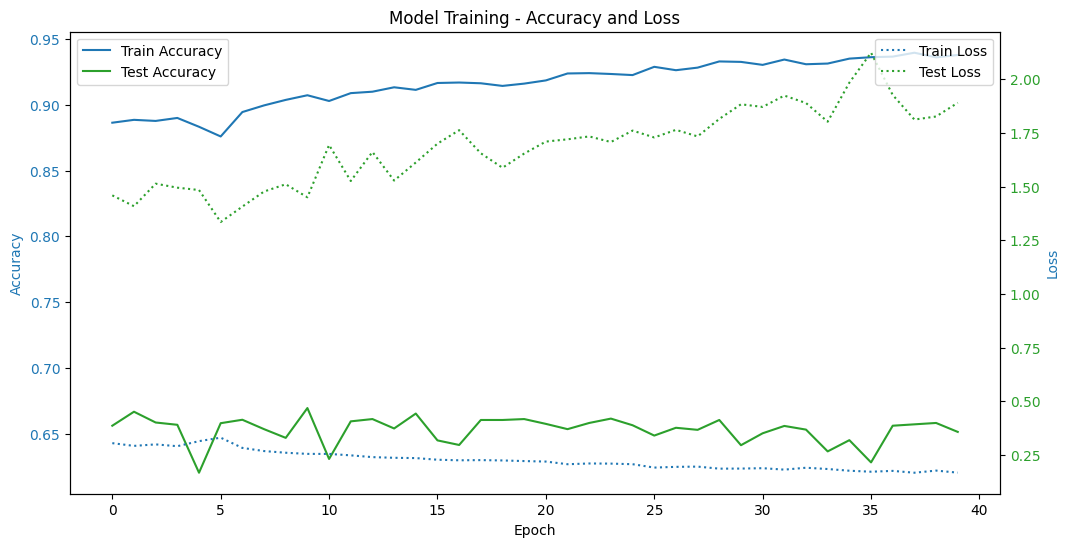

INFO:tensorflow:Assets written to: /home/darksst/Desktop/FacialExpressionRecognitionUsingDensenet121/MODELS/FINALDense/assets


INFO:tensorflow:Assets written to: /home/darksst/Desktop/FacialExpressionRecognitionUsingDensenet121/MODELS/FINALDense/assets


In [18]:
import matplotlib.pyplot as plt

'''# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()'''


# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy on the first y-axis
train_color = 'tab:blue'  # Color for training data
test_color = 'tab:green'  # Color for test data

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=train_color)
ax1.plot(history.history['accuracy'], label='Train Accuracy', color=train_color)
ax1.plot(history.history['val_accuracy'], label='Test Accuracy', color=test_color)
ax1.tick_params(axis='y', labelcolor=train_color)
ax1.legend(loc='upper left')

# Create a second y-axis for the loss with shared x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color=train_color)
ax2.plot(history.history['loss'], label='Train Loss', color=train_color, linestyle='dotted')
ax2.plot(history.history['val_loss'], label='Test Loss', color=test_color, linestyle='dotted')
ax2.tick_params(axis='y', labelcolor=test_color)
ax2.legend(loc='upper right')

# Show the plot
plt.title('Model Training - Accuracy and Loss')
plt.show()


# Save the model
model_save_path = os.path.join(base_path, 'MODELS/FINALDense')
model_save_keras_path = os.path.join(base_path, 'MODELS/FINALDense.keras')
model.save(model_save_path)
model.save(model_save_keras_path, save_format='keras')

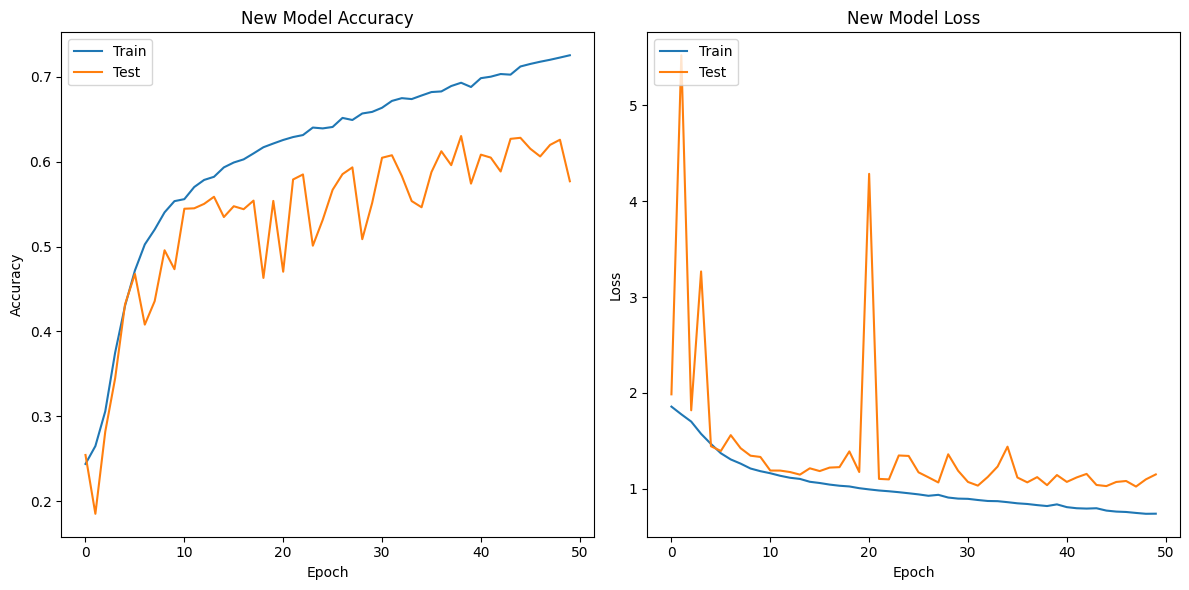

In [5]:
import matplotlib.pyplot as plt

# Summarize history for accuracy of the new model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(new_history.history['accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.title('New Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Summarize history for loss of the new model
plt.subplot(1, 2, 2)
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('New Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()